<a href="https://colab.research.google.com/github/andturken/COVID19-Global-Prediction/blob/master/covid_global_arima_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/COVID19-Global-Prediction
!ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/COVID19-Global-Prediction
 code.py				    kaggle
 covid19countryinfo.csv			    mobility_report.csv
 covid-19-tests-country-mar20-humdata.csv   owid-covid-data.csv
 covid_global_test_arima.ipynb		    owid-covid-data-OurWorldInData.xlsx
 covid-mobility-report-data-extractor	    OxCGRT_latest.txt
 covid_spread.csv			    OxCGRT_timeseries_all.xlsx
 csse_covid_19_daily_reports		    README.md
 csse_covid_19_time_series		    UID_ISO_FIPS_LookUp_Table.csv
 datahub				    who_covid_19_sit_rep_time_series
'fetch latest_data.py'


In [0]:
#%config IPCompleter.greedy=True
# %matplotlib inline

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, statsmodels.api as sm
import os, sys, warnings, io, requests, time, datetime

warnings.simplefilter('ignore')

sys.path.append(os.getcwd())

print(os.getcwd())
#! git clone 
#! wget 


/content/drive/My Drive/COVID19-Global-Prediction


In [0]:
! pip install prophet

In [0]:
df = pd.read_csv('datahub/countries-aggregated.csv').drop(columns=['Recovered']) .reset_index(drop=True)
df['Date'] =  pd.to_datetime(df.Date).dt.strftime("%m-%d")  #.astype(int)
df.head()  #df.sample(5)

cutoff_test = df['Date'] > '04-20'
df_test = df.copy()[cutoff_test]
df = df[~cutoff_test]

In [0]:
dates = df.Date.unique()
df_final = df[df.Date == dates.max()]
top20_countries = df_final.sort_values(by='Confirmed',ascending=False).head(20)['Country'].values.tolist()
top10_countries = df_final.sort_values(by='Confirmed',ascending=False).head(20)['Country'].values.tolist()
df_final.sort_values(by='Confirmed',ascending=False).head(20)

countries_gt1000cases = df_final.Country[df_final.Confirmed > 1000].unique()
df = df[ df.Country.isin(countries_gt1000cases)]
df_final = df_final[ df_final.Country.isin(countries_gt1000cases)]

countries, countries_all = countries_gt1000cases, countries

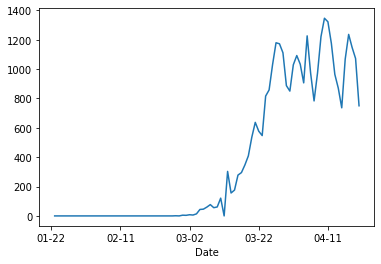

In [0]:
df[df.Country=='Netherlands'].set_index(keys='Date')['Confirmed'].diff().plot()

In [0]:
countries = df.Country.unique()
countries

array(['Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus',
       'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Cameroon',
       'Canada', 'Chile', 'China', 'Colombia', 'Croatia', 'Cuba',
       'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt',
       'Estonia', 'Finland', 'France', 'Germany', 'Ghana', 'Greece',
       'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan',
       'Korea, South', 'Kuwait', 'Lithuania', 'Luxembourg', 'Malaysia',
       'Mexico', 'Moldova', 'Morocco', 'Netherlands', 'New Zealand',
       'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia',
       'Saudi Arabia', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia',
       'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand',
       'Turkey', 'US', 'Ukraine', '

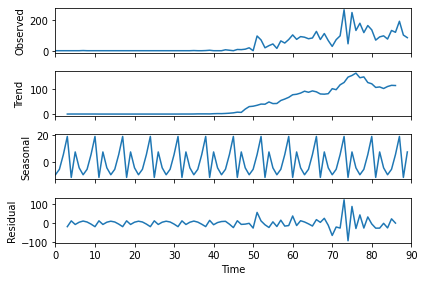

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

#fig, axs = plt.subplots(1,4)
country = 'Finland'

ts = df[df['Country']==country]['Confirmed'].reset_index(drop=True).diff().fillna(0)
res=sm.tsa.seasonal_decompose(ts.values,freq=7)
res.plot( )

test_stat = adfuller(ts, autolag='AIC')

#plot_acf(ts,lags=12,title="ACF")
#plot_pacf(ts,lags=12,title="PACF")

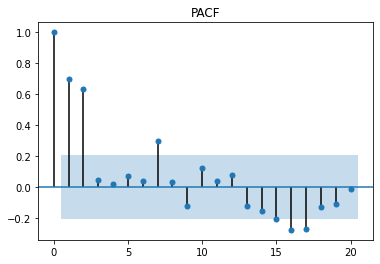

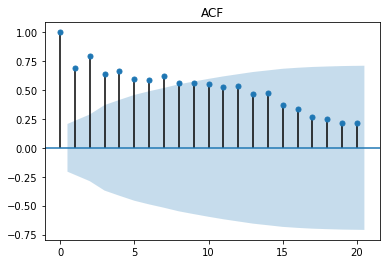

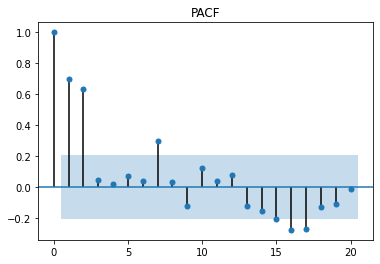

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts,  lags=20,title="ACF")
plot_pacf(ts, lags=20,title="PACF")

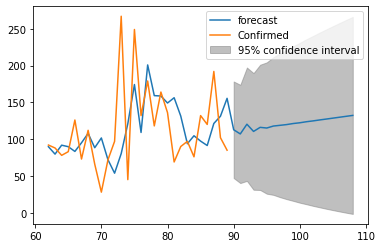

In [0]:
  model = ARIMA(ts, order=(4,1,0))
  result = model.fit()
  result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
  pred=result.forecast(steps=10)[0]
  #Plotting results
  # f,ax=plt.subplots()
  # plt.plot(ts,c='green', label= 'ts')
  # plt.plot(pred,c='red', label= 'predictions')
  # #plt.plot(test, c='red',label='real values')
  # plt.legend()
  # plt.title('arima predictions')
  # #Printing the error metrics
  # print(result.summary()) 

In [0]:
cutoff_val =  '04-01'

df_train = df[df.Date < cutoff_val]
df_val = df[df.Date >= cutoff_val]

dates_train = df_train.Date.unique()
dates_val = df_val.Date.unique()

df = df_train

(-1.0232647593127535, 0.7446847319164319, 8, 61, {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}, -23.979466269778428)


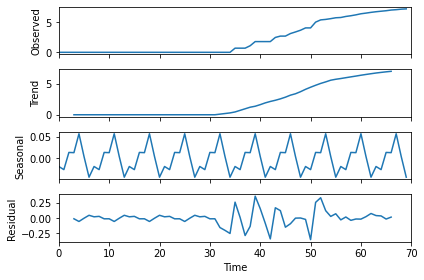

In [0]:
country = 'Finland'

#ts = df[df['Country']==country]['Confirmed'].reset_index(drop=True).diff().fillna(0)
ts = np.log( df[df['Country']==country]['Confirmed'].reset_index(drop=True)).fillna(0).replace(-np.inf,0)
res=sm.tsa.seasonal_decompose(ts.values,freq=7)
res.plot( )

test_stat = adfuller(ts, autolag='AIC')
print(test_stat)

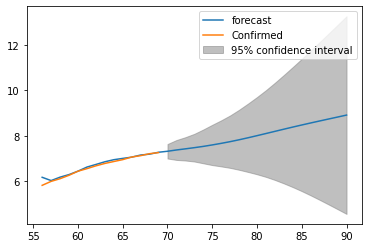

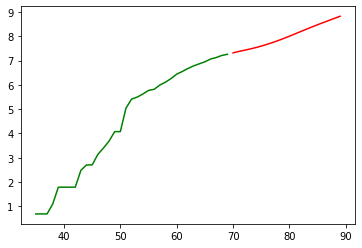

In [0]:
day1 = (ts>0).argmax()
ts_a = ts[day1:]
ix_tsa = np.arange(day1, len(ts))
ix_pred = np.arange( len(ts) , len(ts) + 20) 
model = ARIMA(ts, order=(6,2,2))
result = model.fit()
result.plot_predict(start=int(len(ts)  * 0.8 ), end=int(len(ts) + 20))
#result.plot_predict(start=int(len(ts) * 0.8), end=int(len(ts) * 1.2))
pred=result.forecast(steps=20)[0]
fig, ax = plt.subplots()
ax.plot( ix_tsa, ts_a, c='green', label= 'ts')
ax.plot(ix_pred, pred,c='red', label= 'predictions')

In [0]:

def compute_arima_for_country(country, order, plot=False):
  ts = np.log( df[df['Country']==country]['Confirmed'].reset_index(drop=True)).fillna(0).replace(-np.inf,0).replace(np.inf,0)
  ts_val = np.log( 
      df_val[df_val['Country']==country]['Confirmed'].reset_index(drop=True)).fillna(0).replace(-np.inf,0).replace(np.inf,0)
  day1 = (ts>0).argmax()
  ts_a = ts[day1:]
  ix_tsa = np.arange(day1, len(ts))
  ix_pred = np.arange( len(ts) , len(ts) + len(ts_val)) 
  ix_val = ix_pred
  model = ARIMA(ts, order=order)
  result = model.fit()
  pred=result.forecast(steps=20)[0]
  ts_pred = np.exp(pred)
  ts_val = np.exp(ts_val)
  mape = np.round( np.abs( (ts_val - ts_pred) / ts_val * 100).mean(), 2 )
  if plot:
    fig, ax = plt.subplots()
    ax.plot( ix_tsa, np.exp(ts_a), c='b', label= 'ts')
    ax.plot( ix_val, ts_val, c='yellow', label= 'val')
    ax.plot(ix_pred, ts_pred,c='red', label= 'pred')
  #result.plot_predict(start=int(len(ts)  * 0.8 ), end=int(len(ts) + 20))
  return mape, ts_val, ts_pred, pred

In [0]:
#ARIMA - Hyperparam optimization
orders = [(p,d,q) for p in range(10) for d in range(3) for q in range(3)]

arima_results = []
best_for_all = []
best_for_each_country = dict()

for country in top10_countries:
  
  best_for_country = []
  for order in orders:
    try:
      mape, ts_val, ts_pred, pred = compute_arima_for_country(country=country, order=order, plot=False)
      arima_results.append( [mape, country,order,  ts_val, ts_pred ] )
      if best_for_country == [] or mape < best_for_country[0] :
        best_for_country = (mape, order)
      if best_for_all == [] or mape < best_for_all[0] :
        best_for_all = (mape, order, country)
      print(country, order, mape)
    except :
      print(country, order, '***')
    best_for_each_country[country] = best_for_country

US (0, 0, 0) 99.96
US (0, 0, 1) 99.77
US (0, 0, 2) ***
US (0, 1, 0) 212.72
US (0, 1, 1) 212.94
US (0, 1, 2) 210.84
US (0, 2, 0) 186.15
US (0, 2, 1) 1635.79
US (0, 2, 2) ***
US (1, 0, 0) 56.77
US (1, 0, 1) ***
US (1, 0, 2) ***
US (1, 1, 0) 213.05
US (1, 1, 1) ***
US (1, 1, 2) ***
US (1, 2, 0) 67.37
US (1, 2, 1) 213.08
US (1, 2, 2) 240.88
US (2, 0, 0) 52.84
US (2, 0, 1) ***
US (2, 0, 2) ***
US (2, 1, 0) 212.19
US (2, 1, 1) 226.21
US (2, 1, 2) ***
US (2, 2, 0) 66.12
US (2, 2, 1) 1256.75
US (2, 2, 2) ***
US (3, 0, 0) 33.73
US (3, 0, 1) ***
US (3, 0, 2) ***
US (3, 1, 0) 208.38
US (3, 1, 1) 206.82
US (3, 1, 2) 225.87
US (3, 2, 0) 59.85
US (3, 2, 1) 311.0
US (3, 2, 2) 372.2
US (4, 0, 0) ***
US (4, 0, 1) ***
US (4, 0, 2) ***
US (4, 1, 0) 207.93
US (4, 1, 1) 206.87
US (4, 1, 2) 245.54
US (4, 2, 0) 70.4
US (4, 2, 1) 1262.76
US (4, 2, 2) 1257.64
US (5, 0, 0) 4.56
US (5, 0, 1) ***
US (5, 0, 2) ***
US (5, 1, 0) 210.82
US (5, 1, 1) 155.65
US (5, 1, 2) 162.7
US (5, 2, 0) 85.92
US (5, 2, 1) 858.38
US 

In [0]:
#ARIMA - Hyperparam optimization
orders = [(p,d,q) for p in range(10) for d in range(3) for q in range(3)]
params = 

arima_results = []
best_for_all = []
best_for_each_country = dict()

for country in top10_countries:
  
  best_for_country = []
  for order in orders:
    try:
      mape, ts_val, ts_pred, pred = compute_arima_for_country(country=country, order=order, plot=False)
      arima_results.append( [mape, country,order,  ts_val, ts_pred ] )
      if best_for_country == [] or mape < best_for_country[0] :
        best_for_country = (mape, order)
      if best_for_all == [] or mape < best_for_all[0] :
        best_for_all = (mape, order, country)
      print(country, order, mape)
    except :
      print(country, order, '***')
    best_for_each_country[country] = best_for_country

US (0, 0, 0) 99.96
US (0, 0, 1) 99.77
US (0, 0, 2) ***
US (0, 1, 0) 212.72
US (0, 1, 1) 212.94
US (0, 1, 2) 210.84
US (0, 2, 0) 186.15
US (0, 2, 1) 1635.79
US (0, 2, 2) ***
US (1, 0, 0) 56.77
US (1, 0, 1) ***
US (1, 0, 2) ***
US (1, 1, 0) 213.05
US (1, 1, 1) ***
US (1, 1, 2) ***
US (1, 2, 0) 67.37
US (1, 2, 1) 213.08
US (1, 2, 2) 240.88
US (2, 0, 0) 52.84
US (2, 0, 1) ***
US (2, 0, 2) ***
US (2, 1, 0) 212.19
US (2, 1, 1) 226.21
US (2, 1, 2) ***
US (2, 2, 0) 66.12
US (2, 2, 1) 1256.75
US (2, 2, 2) ***
US (3, 0, 0) 33.73
US (3, 0, 1) ***
US (3, 0, 2) ***
US (3, 1, 0) 208.38
US (3, 1, 1) 206.82
US (3, 1, 2) 225.87
US (3, 2, 0) 59.85
US (3, 2, 1) 311.0
US (3, 2, 2) 372.2
US (4, 0, 0) ***
US (4, 0, 1) ***
US (4, 0, 2) ***
US (4, 1, 0) 207.93
US (4, 1, 1) 206.87
US (4, 1, 2) 245.54
US (4, 2, 0) 70.4
US (4, 2, 1) 1262.76
US (4, 2, 2) 1257.64
US (5, 0, 0) 4.56
US (5, 0, 1) ***
US (5, 0, 2) ***
US (5, 1, 0) 210.82
US (5, 1, 1) 155.65
US (5, 1, 2) 162.7
US (5, 2, 0) 85.92
US (5, 2, 1) 858.38
US 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


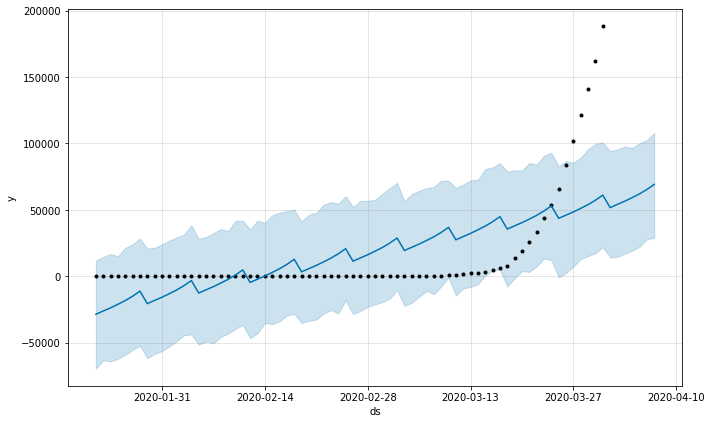

In [0]:
from fbprophet import Prophet

#df_p.ds = df_p.ds.apply(lambda x : '2020-'  + x ) 
#df_p.ds = pd.to_datetime(df_p.ds)
#df_p.ds.iloc[:] # = pd.to_datetime(df_p.ds)
df_p = df_train[df_train.Country == 'US' ][['Date','Confirmed']] #.set_index('keys'='Date')
df_p.columns = ['ds', 'y']  #we need to rename the columns in our dataframe to be ds and y
df_p.ds = df_p.ds.apply(lambda x : '2020-'  + x ) 

model = Prophet()
model.fit(df_p )
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

plot1 = model.plot(forecast)